# Model Training and Evaluation
**Author:** Enej Podlipnik  
**Affiliation:** University of Ljubljana, Faculty of Mechanical Engineering  
**Date:** June 2024

This notebook is part of the diploma project "Impact Location and Force Prediction."  
For full context, see the repository.

## Purpose
This notebook demonstrates the training, evaluation, and hyperparameter tuning of the impact prediction model.

It is intended for academic and non-commercial use.

## Requirements
- Python packages listed in requirements.txt

---

## 1. Imports and List Available Functions

In [ ]:
import functions
functions.list_functions()

ImpactPredictor - ML model
ImpactDataset - Make dataset
make_dataloaders - Make dataloaders form the dataset
train_model - Function to train the model
save_model_weights - Saves the model weights
load_model_weights - Loads model weights
gather_data - Function for gathering data via LDAQ (open NI-MAX)
plot_data - Plots data form the dictionary of gather_data()
plot_loss_curves - Plots the loss curves of the traing proces
open_pkl_dict - Opens a specified .pkl file and loads it as a dict
live_inference - Performes live inference directly after gathering data
save_model_results - Saves the dictionary of the model results to .pkl
plot_inference - Plots predictions of the model vs. the labels
print_model_summary - Print the parameters of the model
prediction_heatmap - Makes a heatmap based on the location of predictions
generate_latin_hypercube_points - Generate random sample points with LHC distribution (x,y,F)
run_random_sampling - Runs the sampling with gather_data and samples across the

## 2. Model Definition

In [ ]:
# Model definition
model = functions.ImpactPredictor(
    num_sensors=4,
    sequence_length=13,
    cnn_filters=[32, 64, 128, 256],
    kernel_size=5,
    pool_size=2,
    force_reg=False,
    loc_class=False,
    dropout_rate=0,
    grid_resolution=(3,3),
    latent_dim=256,
    head_hidden_dim=256,
    head_hidden_layers=5
)

## 3. Dataset Preparation

In [ ]:
# Make datasets with the filtered data
dataset = functions.ImpactDataset(
    data_dir="data/filtered_data_grid/filtered_cutoff_100",
    force_regression=False,
    trim_data=True, # hard set to trim to 0.12 s when sample time is 0.3s
    loc_class=False,
    grid_size=(3,3),
    classification_boundaries=(20, 30),
    skip_data=80
)

# Make dataloader
train_dataloader, test_dataloader = functions.make_dataloaders(
    dataset=dataset,
    train_frac=0.8,
    batch_size=32
)
print(len(next(iter(dataset))[0]))

## 4. Optimizer and Loss Functions

In [ ]:
import torch
import torch.nn as nn

loss_loc = nn.MSELoss()
loss_force = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=5e-6)

## 5. Model Training

In [ ]:
model_results = functions.train_model(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    num_epochs=150,
    optimizer=optimizer,
    criterion_force=loss_force,
    criterion_loc=loss_loc,
    loss_weight_force=(1, 1),
    loss_weight_loc=(1, 1), # linearly changes during training
    early_stop_patience=20
)

## 6. Save Results and Model Weights

In [ ]:
MODEL_RESULTS = "model_017_v24c_dict"
MODEL_WEIGHTS = "model_017_v24c"
functions.save_model_results(dir_name="model_results", file_name=MODEL_RESULTS, model_results_dict=model_results)
functions.save_model_weights(model=model, dir_name="model_weights", weights_name=MODEL_WEIGHTS)

## 7. Hyperparameter Grid Search

In [ ]:
cutoff_freqs = list(range(100, 1001, 100))
downsample_rates = list(range(10, 101, 10))

results = []
for cutoff in cutoff_freqs:
    for downsample in downsample_rates:
        # Generate dataset and dataloader
        dataset = functions.ImpactDataset(
            data_dir=f"data/filtered_data_grid/filtered_cutoff_{cutoff}",
            loc_class=False,
            trim_data=True,
            grid_size=(3,3),
            force_regression=False,
            classification_boundaries=(20, 30),
            skip_data=downsample
        )
        train_dataloader, test_dataloader = functions.make_dataloaders(
            dataset=dataset,
            train_frac=0.8,
            batch_size=32
        )
        
        # Train model and get results
        model = functions.ImpactPredictor(
            num_sensors=4,
            sequence_length=13,
            cnn_filters=[32, 64, 128, 256],
            kernel_size=5,
            pool_size=2,
            force_reg=False,
            loc_class=False,
            dropout_rate=0,
            grid_resolution=(3,3),
            latent_dim=256,
            head_hidden_dim=256,
            head_hidden_layers=5
        )
                
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=5e-6)
        loss_loc = nn.MSELoss()
        loss_force = nn.CrossEntropyLoss()

        model_results = functions.train_model(
            model=model,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            num_epochs=150,
            optimizer=optimizer,
            criterion_loc=loss_loc,
            criterion_force=loss_force,
            loss_weight_loc=(1, 10),
            loss_weight_force=(1, 1),
            early_stop_patience=20
        )
        
        # Record validation metric
        val_loss = model_results["test_loss"][-1]
        results.append({
            "cutoff" : cutoff,
            "skip" : downsample,
            "test_loss" : val_loss
        })
        print(f"Cutoff: {cutoff} | downsample: {downsample} -> Test loss: {val_loss}")

## 8. Analyze and Save Top Results

In [ ]:
# Print out optimal parameters
opt_params = {"cutoff" : 10, "skip" : 10, "test_loss" : 9999}
loss_vals = []
for idx, i in enumerate(results):
    loss_vals.append(i["test_loss"])
    if i["test_loss"] < opt_params["test_loss"]:
        opt_params = i

sorted_vals = sorted(loss_vals)
sorted_vals = sorted_vals[:10] # top 10 loss_vals 

top_results = []
for loss in sorted_vals:
    for result in results:
        if result["test_loss"] == loss:
            top_results.append(result)
            break # ensures that if there are duplicate losses, we only add one of the results
top_results_dict = {"top_results": top_results}

functions.save_model_results(dir_name="filter_parameters", file_name="top_10_results_cutoff_downsample", model_results_dict=top_results_dict)

Saved dict to: filter_parameters\top_10_results_cutoff_downsample.pkl


In [124]:
# load data dict with the top results
top_results = functions.open_pkl_dict(file_path="filter_parameters/top_10_results_cutoff_downsample.pkl")
top_results["top_results"]

[{'cutoff': 900, 'skip': 60, 'test_loss': 0.001210193052732696},
 {'cutoff': 900, 'skip': 100, 'test_loss': 0.003688327968120575},
 {'cutoff': 800, 'skip': 100, 'test_loss': 0.004406509688124061},
 {'cutoff': 100, 'skip': 80, 'test_loss': 0.004990524495951831},
 {'cutoff': 1000, 'skip': 30, 'test_loss': 0.00543355627451092},
 {'cutoff': 900, 'skip': 40, 'test_loss': 0.0059389751792574925},
 {'cutoff': 200, 'skip': 50, 'test_loss': 0.006975318227584164},
 {'cutoff': 500, 'skip': 40, 'test_loss': 0.007249484226728479},
 {'cutoff': 800, 'skip': 60, 'test_loss': 0.007255091603534917},
 {'cutoff': 600, 'skip': 30, 'test_loss': 0.007454162347130477}]

In [74]:
functions.save_model_weights(model=model, dir_name="model_weights", weights_name="model_017_v15c")
functions.save_model_results(dir_name="model_results", file_name="model_017_v15c_dict", model_results_dict=model_results)

Saved dict to: model_weights\model_017_v15c.pkl
Saved dict to: model_results\model_017_v15c_dict.pkl


## 9. Test Hyperparameters

In [4]:
dataset = functions.ImpactDataset(data_dir="data/remapped_data",
                                  loc_class=False, # hyperparameter search je hard coded na loc_reg in force_class
                                  trim_data=True,
                                  grid_size=(3,3),
                                  force_regression=False,
                                  classification_boundaries=(20,30))


zero_arg_model = lambda: functions.model_factory(num_sensors=4,
                                                          sequence_length=6144,
                                                          cnn_filters=[32, 64, 128, 256],
                                                          kernel_size=5,
                                                          pool_size=2,
                                                          force_reg=False,
                                                          loc_class=False,
                                                          dropout_rate=0,
                                                          grid_resolution=(3,3),
                                                          latent_dim=256,
                                                          head_hidden_dim=256,
                                                          head_hidden_layers=5)

zero_arg_dataloader = lambda: functions.dataset_factory(dataset=dataset,
                                                        batch_size=32,
                                                        train_frac=0.8)

len(dataset)

1680

In [ ]:
### Test hyperparameters
optimal_params = functions.hyperparameter_search(model_factory=zero_arg_model(),
                                                 dataset_factory=zero_arg_dataloader,
                                                 lr_range=(1e-2, 1e-6),
                                                 wd_range=(1e-3, 1e-7),
                                                 loc_w_range=(1, 1000),
                                                 n_trials=100,
                                                 epochs_per_trial=20)

## 10. Remap Data

In [ ]:
functions.cluster_location_labels(data_dir="data/LHC_sampling_10samples",
                                  grid_resoulution=(3,3),
                                  overwrite=False,
                                  output_dir="data/remapped_data")

## 11. Show Model Results

In [57]:
# Model definition
model = functions.ImpactPredictor(num_sensors=4,
                        sequence_length=62,
                        cnn_filters=[32, 64, 128, 256],
                        kernel_size=5,
                        pool_size=2,
                        force_reg=False,
                        loc_class=False,
                        dropout_rate=0,
                        grid_resolution=(3,3),
                        latent_dim=256,
                        head_hidden_dim=256,
                        head_hidden_layers=5)



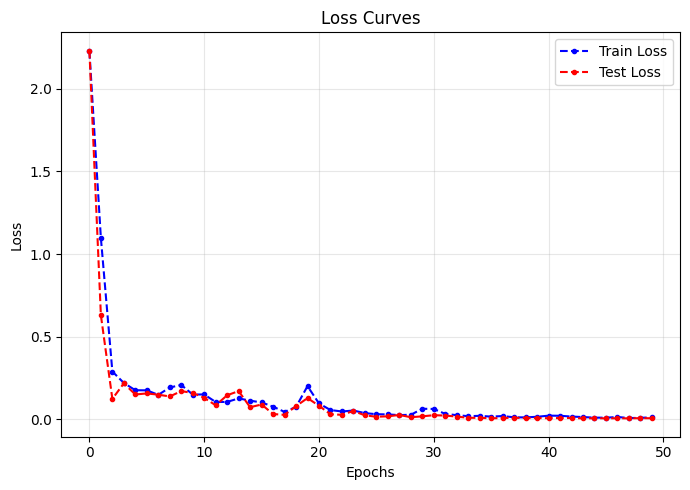

In [6]:
model_results = functions.open_pkl_dict(file_path="model_results/" + "model_017_v16c_dict"+ ".pkl")
functions.plot_loss_curves(model_results)

Tensor after downsampling: torch.Size([103, 4])
The model predicted the impact at coord: (0.4255223274230957, 0.4335384666919708)


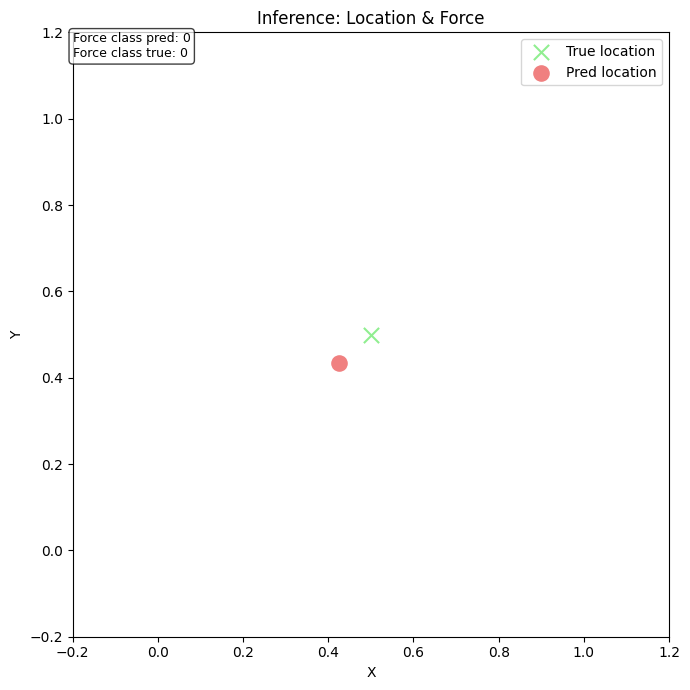

In [59]:
data_dict = functions.open_pkl_dict(file_path="data/filtered_data_grid/filtered_cutoff_100/0.5_0.5_15_30.pkl")
functions.plot_inference(data_dict=data_dict,
                         model=model,
                         weight_path="model_weights/" + MODEL_WEIGHTS + ".pkl",
                         board_size_xy=(1,1),
                         class_boundaries=(20,30),
                         grid_size=(3,3),
                         trim_duration=0.12,
                         skip_data=60)

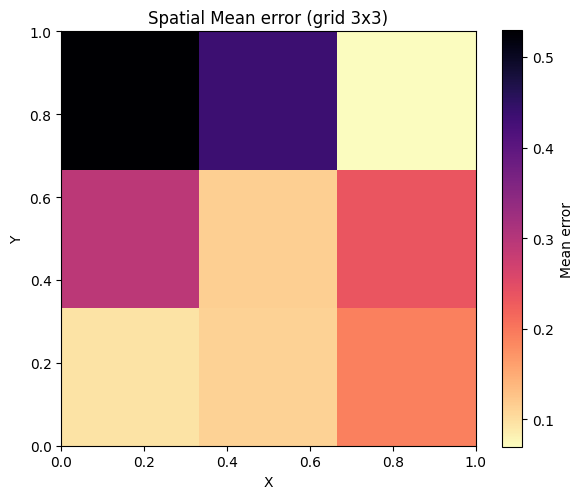

In [60]:
functions.prediction_heatmap(model=model,
                             weight_path="model_weights/" + MODEL_WEIGHTS + ".pkl",
                             data_dir="data/filtered_data_grid/filtered_cutoff_100",
                             board_size_xy=(1,1),
                             grid_res=(3,3),
                             skip_data=60,
                             trim_duration=0.12,
                             verbose=False)


In [ ]:
functions.print_model_summary(model=model, input_size=(32, 6144, 4))

## References
- This code is part of: Enej Podlipnik, "Impact Location and Force Prediction," Undergraduate Diploma Thesis, University of Ljubljana, Faculty of Mechanical Engineering, 2024.
- Repository: [add your repository URL here]